In [ ]:

import omegaconf
from utils.data import DataLoader
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from utils.model import PosPredictor
from utils.tracker import Tracker
import glob
import numpy as np

In [3]:
conf = omegaconf.OmegaConf.load('configs/baseConfig.yaml')
conf.LoaderParams.norm = False
conf.LoaderParams.ParticleNumber = 100
train_loader = DataLoader('data/train',**conf.LoaderParams)

# Tracking for PG

In [4]:
device = 'cpu'

In [5]:
def loadPretrainedModel(path):
    conf = omegaconf.OmegaConf.load(path+"/config.yaml")
    model = PosPredictor(**conf.ModelParams)
    model.initSinkhornArgs(**conf.SinkhornParams)
    model.compile(optimizer=torch.optim.Adam,loss=torch.nn.MSELoss,device = device)
    model.load_state_dict(torch.load(path+"/model.pth"))
    return model

In [6]:
def CorrectionMask(S,Sinkhorn = False):
    xpreds = torch.argmin(S,dim=1) if not Sinkhorn else torch.argmax(S,dim=1)
    ypreds = torch.argmin(S,dim=2) if not Sinkhorn else torch.argmax(S,dim=2)
    #x_prev[torch.arange(x_prev.size(0)).unsqueeze(1),xpreds] == 0
    #zmask = x_prev == 0 #+x_prev[torch.arange(x_prev.size(0)).unsqueeze(1),ypreds] == 0
    return (xpreds == ypreds) #+ zmask.all(dim = -1)

In [7]:
#modelPaths =["runs_PosPred/Mar14_14-45-59_cluster6_targetLayer_0","runs_PosPred/Mar14_16-10-32_cluster6_targetLayer_1","runs_PosPred/Mar14_17-36-39_cluster6_targetLayer_2"]
#modelList = [loadPretrainedModel(path) for path in modelPaths]


In [ ]:
tracker = Tracker(modelList)
tracker.add_loader(train_loader)

: 

: 

: 

In [9]:
batch = torch.from_numpy(next(iter(train_loader)))
#res = tracker.tracking(batch,maxLayer=10,useSinkhorn=True)

In [8]:
def SinkhornMatch(x1,x2,temp = .9,n_iter:int = 10):
    distMX = torch.cdist(x1,x2,p=2)
    S = torch.softmax(-distMX/temp,dim=1)
    for _ in range(n_iter):
        S /= torch.sum(S,dim=1,keepdim=True)
        S /= torch.sum(S,dim=2,keepdim=True)
    mask = None#self.CorrectionMask(S,x_prev,Sinkhorn=True)
    res = torch.argmax(S,dim=1)
    return res,mask

def match(x1,x2):
    distMX = torch.cdist(x1,x2,p=2)
    LikelyMatches = torch.argmin(distMX,dim=1)
    #mask = CorrectionMask(distMX)
    return LikelyMatches, None#mask


# Old Stuff

In [10]:
x_target = batch[:,:,0]
x_prev = batch[:,:,1]
x_prev2 = batch[:,:,2]


batch.shape

torch.Size([256, 100, 41, 3])

In [18]:
for t in np.arange(0.1,1.,.1):
    acc = 0.
    LikelyMatches, Mask = SinkhornMatch(x_target,x_prev,temp= t)
    for idx in range(batch.shape[0]):
        res = x_target[idx][LikelyMatches[idx]].eq(x_target[idx]).sum()/3
        acc += res.item()
    print(acc/batch.shape[0])

#modelRes = modelList[0](x_prev,x_prev2)
#acc = 0.
#LikelyMatches, Mask = SinkhornMatch(x_target,modelRes)
#for idx in range(batch.shape[0]):
#    res = x_target[idx][LikelyMatches[idx]].eq(x_target[idx]).sum()/3
#    acc += res.item()
#print(acc/batch.shape[0])


54.01171875
56.8671875
59.8828125
61.60546875
63.21484375
64.296875
65.43359375
66.5546875
66.4921875


In [20]:
acc = 0.
LikelyMatches, Mask = SinkhornMatch(x_target,x_prev,temp= 1.)
for idx in range(batch.shape[0]):
    res = x_target[idx][LikelyMatches[idx]].eq(x_target[idx]).sum()/3
    acc += res.item()
print('Batchwise accuracy:',acc/batch.shape[0])

Batchwise accuracy: 66.1171875


In [ ]:
bacc = 0.
for i, batch in enumerate(train_loader):
    batch = torch.from_numpy(batch)
    x_target = batch[:,:,0]
    x_prev = batch[:,:,1]
    acc = 0.
    LikelyMatches, Mask = SinkhornMatch(x_target,x_prev,temp= 1.)
    for idx in range(batch.shape[0]):
        res = x_target[idx][LikelyMatches[idx]].eq(x_target[idx]).sum()/3
        acc += res.item()
    resacc = acc/batch.shape[0]
    bacc +=resacc
    print('Batchwise accuracy:',resacc)
    if i == 20:
        break


Batchwise accuracy: 65.55859375
Batchwise accuracy: 65.04296875
Batchwise accuracy: 65.1640625
Batchwise accuracy: 66.61328125
Batchwise accuracy: 66.125
Batchwise accuracy: 66.22265625
Batchwise accuracy: 65.80859375
Batchwise accuracy: 66.6015625
Batchwise accuracy: 65.97265625
Batchwise accuracy: 67.296875
Batchwise accuracy: 66.42578125
Batchwise accuracy: 66.1171875
Batchwise accuracy: 66.0625
Batchwise accuracy: 67.375
Batchwise accuracy: 66.8515625
Batchwise accuracy: 66.63671875
Batchwise accuracy: 66.53125
Batchwise accuracy: 66.9609375
Batchwise accuracy: 65.64453125
Batchwise accuracy: 66.4296875
Batchwise accuracy: 67.109375
Overall Accuracy: 69.6275390625


In [26]:
print('Overall Accuracy:', bacc/21)

Overall Accuracy: 66.31194196428571


In [25]:
sf1 = nn.Softmax(dim=2)
sf1(modelRes).shape


torch.Size([256, 100, 3])

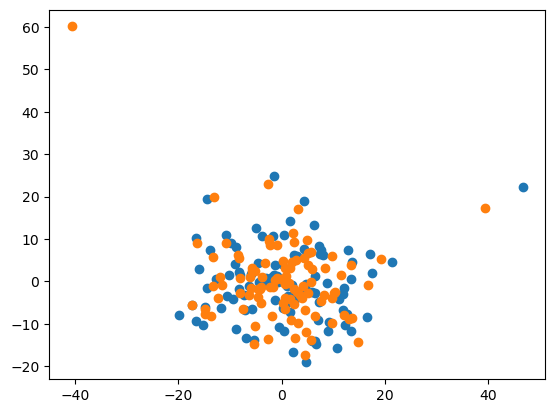

In [35]:
plt.scatter(modelRes[0,:,0].detach().numpy(),modelRes[0,:,1].detach().numpy())
plt.scatter(x_target[0,:,0].numpy(),x_target[0,:,1].numpy())

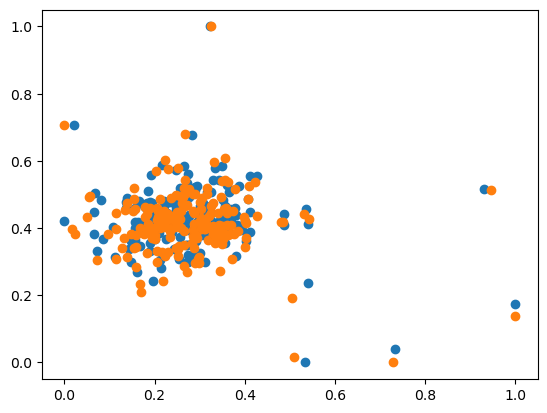

In [13]:
normalize = lambda x: (x - x.min()) / (x.max() - x.min())
plt.scatter(normalize(modelRes[0,:,0].detach().numpy()),normalize(modelRes[0,:,1].detach().numpy()))
plt.scatter(normalize(x_target[0,:,0].numpy()),normalize(x_target[0,:,1].numpy()))

In [14]:
distMX = torch.cdist(modelRes,x_target)
distMX.shape
mask = CorrectionMask(distMX,Sinkhorn= False)

In [15]:
LikelyMatches = torch.argmin(distMX,dim=1)
LikelyMatches.shape

torch.Size([256, 200])

In [16]:
x_target[0].eq(x_target[0][LikelyMatches[0]]).sum()/x_target.shape[1]

tensor(0.8850)

# Testing Matching

In [17]:
def CorrectionMask(S):
    xpreds = torch.argmin(S,dim=1)
    ypreds = torch.argmin(S,dim=2)
    return xpreds == ypreds

In [18]:
def match(x1,x2):
    distMX = torch.cdist(x1,x2,p=2)
    LikelyMatches = torch.argmin(distMX,dim=1)
    mask = CorrectionMask(distMX)
    return LikelyMatches, mask


In [19]:
def SinkhornMatch(x1,x2,temp = .9,n_iter:int = 10):
    distMX = torch.cdist(x1,x2,p=2)
    S = torch.softmax(-distMX/temp,dim=1)
    for _ in range(n_iter):
        S /= torch.sum(S,dim=1,keepdim=True)
        S /= torch.sum(S,dim=2,keepdim=True)
    mask = None#self.CorrectionMask(S,x_prev,Sinkhorn=True)
    res = torch.argmax(S,dim=1)
    return res,mask

In [20]:
x_target = batch[:,:,0]
x1= batch[:,:,1]
x2 = batch[:,:,2]
x_prev = modelList[0](x2,x1)
distMX = torch.cdist(x_target,x_prev)

LikelyMatches = torch.argmin(distMX,dim=2)
idxs = LikelyMatches[0]
t = x_target[0]
torch.mean((t[idxs] == t)*1.)

tensor(0.7550)

In [62]:
targetLayer = 0
t = 1
for i in range(10):
    batch = torch.from_numpy(next(iter(train_loader)))
    x_target = batch[:,:,targetLayer]
    x1= batch[:,:,targetLayer+1]
    x2 = batch[:,:,targetLayer+2]
    x_prev = x1 if targetLayer >= len(modelList) else modelList[targetLayer](x2,x1)
    LikelyMatches, mask = match(x_target,x_prev)
    acc = x_target[torch.arange(x_target.size(0)).unsqueeze(1),LikelyMatches].eq(x_target).sum()/(x_target.numel())
    SinkhornMatches,_ = SinkhornMatch(x_prev,x_target,temp= t)
    SinkhorNacc = x_target[torch.arange(x_target.size(0)).unsqueeze(1),SinkhornMatches].eq(x_target).sum()/(x_target.numel())

    print(f"Accurcy: {acc.item():.3f}, temp: {t} Sinkhorn acc: {SinkhorNacc:.3f}")

Accurcy: 0.739, temp: 1 Sinkhorn acc: 0.783
Accurcy: 0.743, temp: 1 Sinkhorn acc: 0.783
Accurcy: 0.740, temp: 1 Sinkhorn acc: 0.781
Accurcy: 0.741, temp: 1 Sinkhorn acc: 0.783
Accurcy: 0.743, temp: 1 Sinkhorn acc: 0.782
Accurcy: 0.742, temp: 1 Sinkhorn acc: 0.782
Accurcy: 0.745, temp: 1 Sinkhorn acc: 0.788
Accurcy: 0.739, temp: 1 Sinkhorn acc: 0.784
Accurcy: 0.742, temp: 1 Sinkhorn acc: 0.783
Accurcy: 0.740, temp: 1 Sinkhorn acc: 0.782


In [63]:
targetLayer = 0
t = 1
batch = torch.from_numpy(next(iter(train_loader)))
x_target = batch[:,:,targetLayer]
x1= batch[:,:,targetLayer+1]
x2 = batch[:,:,targetLayer+2]
x_prev = x1 if targetLayer >= len(modelList) else modelList[targetLayer](x2,x1)
LikelyMatches, mask = match(x_target,x_prev)
purity,acc, numRec, = 0,0,0
y = x_target


In [64]:
y.shape[0],mask

(256,
 tensor([[False,  True,  True,  ...,  True,  True,  True],
         [False,  True, False,  ..., False,  True, False],
         [False, False,  True,  ...,  True,  True,  True],
         ...,
         [False, False, False,  ...,  True,  True, False],
         [False,  True,  True,  ...,  True,  True,  True],
         [ True,  True,  True,  ...,  True, False, False]]))

In [65]:
for b in range(y.shape[0]):
    numReconstructed = torch.sum(mask[b])
    
    numRec += numReconstructed
    truepoints = y[b]
    truepoints_masked = truepoints[mask[b]]
    comparepoints = y[b,LikelyMatches[b]]
    comparepoints_masked = comparepoints[mask[b]]

    purity += torch.sum(comparepoints_masked == truepoints_masked)/(3*numReconstructed)
    acc += torch.sum(comparepoints_masked == truepoints_masked)/(3*y.shape[1])
purity /= y.shape[0]
acc /= y.shape[0]
print(f"Accurcy: {acc.item():.3f}, Purity: {purity.item():.3f}, numRec: {numRec.item()}")

Accurcy: 0.636, Purity: 0.920, numRec: 35379


# Evaluate tracking

In [21]:
tracks = torch.zeros(batch.shape)

In [23]:
def evalTrack(batch,useSinkhorn:bool = True ,temp = 0.1):
    tracks = torch.zeros(batch.shape)
    for targetLayer in range(39):
        x_target = batch[:,:,targetLayer]
        x1 = batch[:,:,targetLayer+1]
        x2 = batch[:,:,targetLayer+2]
        x_prev = x1 if targetLayer >= len(modelList) else modelList[targetLayer](x2,x1)
        SinkhornMatches,_ = SinkhornMatch(x_prev,x_target,temp= temp) if useSinkhorn else match(x_prev,x_target)
        reconstructed = x_target[torch.arange(x_target.size(0)).unsqueeze(1),SinkhornMatches]         
        tracks[:,:,targetLayer] = reconstructed
    y_true = batch[:,:,:]
    y_pred = tracks[:,:,:]
    comp = y_true == y_pred
    numPureTracks = comp.all(dim = -1).all(dim = -1).sum()
    pureTrackRatio = numPureTracks/(comp.shape[0]*comp.shape[1])
    print(f"Accurcy: {comp.sum()/(comp.numel())}")
    return y_true,y_pred    

In [24]:
for t in [.1,.3,.5,.7,.9,1.1,1.3,1.5]:
    print(f"Temp: {t}")
    evalTrack(batch,t)
    print("\n\n")

Temp: 0.1
Accurcy: 0.9381449818611145



Temp: 0.3
Accurcy: 0.9381449818611145



Temp: 0.5
Accurcy: 0.9381449818611145



Temp: 0.7
Accurcy: 0.9381449818611145



Temp: 0.9
Accurcy: 0.9381449818611145



Temp: 1.1
Accurcy: 0.9381449818611145



Temp: 1.3
Accurcy: 0.9381449818611145



Temp: 1.5
Accurcy: 0.9381449818611145





In [26]:
tracks = torch.zeros(batch.shape)
for targetLayer in range(39):
    x_target = batch[:,:,targetLayer]
    x1 = batch[:,:,targetLayer+1]
    x2 = batch[:,:,targetLayer+2]
    x_prev = x1 if targetLayer >= len(modelList) else modelList[targetLayer](x2,x1)
    
    LikelyMatches, _ = match(x_target,x_prev)
    SinkhornMatches,_ = SinkhornMatch(x_prev,x_target,temp= 0.001)
    reconstructed = x_target[torch.arange(x_target.size(0)).unsqueeze(1),SinkhornMatches] 
    SinkhorNacc =reconstructed.eq(x_target).sum()/(x_target.numel())
    
    tracks[:,:,targetLayer] = reconstructed
    print(f"Accurcy: {acc.item():.3f} Sinkhorn acc: {SinkhorNacc:.3f}")
    y_true = batch[:,:,:]
    y_pred = tracks[:,:,:]
    comp = y_true == y_pred
    pureTrackRatio = comp.all(dim = -1).all(dim = -1).sum()/comp.shape[0]
    print(f"Accurcy: {comp.sum()/(comp.numel())}")
    print(f"PureTrackRatio: {pureTrackRatio}")

NameError: name 'acc' is not defined

In [96]:
y_true = batch[:,:,:]
y_pred = tracks[:,:,:]

In [97]:
comp = y_true == y_pred
comp.sum()/(comp.numel())   

tensor(0.4056)

In [103]:
y_true[0,0] == y_pred[0,0]

tensor([[True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True, True],
        [True, True,

In [98]:
comp.all(dim = -1).all(dim = -1).sum()/comp.shape[0]

tensor(0.5859)

In [80]:
res = tracks.eq(batch)
trackrecacc = res.sum()/res.numel()
print(trackrecacc)

tensor(0.9083)
